In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

import matplotlib.pyplot as plt

import pathlib
import time
AUTOTUNE = tf.data.AUTOTUNE

from tf_augmentation import ds_augment, rotate_flip_shuffle
from get_model import *
from utils import *

In [2]:
data_dir = pathlib.Path("C:/Users/AORUS/dataset")

In [3]:
BATCH_SIZE = 16
IMG_SIZE = 96
VAL_BATCH_SIZE = 64

FREEZE_EPOCHS = 15
UNFREEZE_EPOCHS = 15

FREEZE_LR = 1e-4
UNFREEZE_LR = 1e-5

In [4]:
train_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
val_ds : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_num_images = len(train_ds.file_paths)
val_num_images = len(val_ds.file_paths)
print(class_names)
print(f"num: {num_classes}")
print(f"train imgs: {train_num_images}")
print(f"val imgs: {val_num_images}")
train_ds_ = rotate_flip_shuffle(train_ds.cache(str(data_dir / "train_ds")).unbatch(), train_num_images)
val_ds_ = rotate_flip_shuffle(val_ds.cache(str(data_dir / "val_ds")).unbatch(), val_num_images)

train_ds = ds_augment(train_ds_).batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds = ds_augment(val_ds_).batch(VAL_BATCH_SIZE, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Found 2368 files belonging to 15 classes.
Found 2368 files belonging to 15 classes.
['apple', 'banana', 'bus', 'car', 'cat', 'cow', 'dog', 'durian', 'grape', 'horse', 'orange', 'pig', 'plane', 'ship', 'train']
num: 15
train imgs: 2368
val imgs: 2368


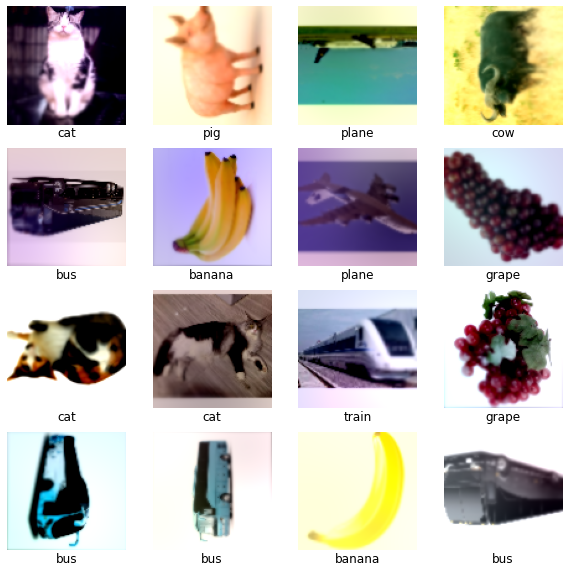

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255)
        plt.title(class_names[labels[i]], y=-0.15)
        plt.axis("off")

In [6]:
export_path = f"D:/SmartCar/TFLite_Smartcar/saved_models/{int(time.time())}"
print(export_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=export_path,
    save_best_only=True,
    monitor="val_loss",
    mode='min',
)

historyViewer = HistoryViewer()

D:/SmartCar/TFLite_Smartcar/saved_models/1659514821


In [7]:
base_model, model = get_EfficientNetV2B1(IMG_SIZE, num_classes, trainable=False)
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 19,215


Epoch 1/15
1184/1184 [==============================] - 67s 47ms/step - loss: 1.4560 - accuracy: 0.6074 - val_loss: 0.7705 - val_accuracy: 0.8234
Epoch 2/15
1184/1184 [==============================] - 74s 58ms/step - loss: 0.6809 - accuracy: 0.8203 - val_loss: 0.5050 - val_accuracy: 0.8677
Epoch 3/15
1184/1184 [==============================] - 88s 70ms/step - loss: 0.5116 - accuracy: 0.8550 - val_loss: 0.4060 - val_accuracy: 0.8881
Epoch 4/15
1184/1184 [==============================] - 99s 79ms/step - loss: 0.4386 - accuracy: 0.8685 - val_loss: 0.3526 - val_accuracy: 0.8970
Epoch 5/15
1184/1184 [==============================] - 106s 84ms/step - loss: 0.3890 - accuracy: 0.8798 - val_loss: 0.3129 - val_accuracy: 0.9065
Epoch 6/15
1184/1184 [==============================] - 111s 88ms/step - loss: 0.3587 - accuracy: 0.8846 - val_loss: 0.2897 - val_accuracy: 0.9144
Epoch 7/15
1184/1184 [==============================] - 118s 94ms/step - loss: 0.3399 - accuracy: 0.8902 - val_loss: 0.268

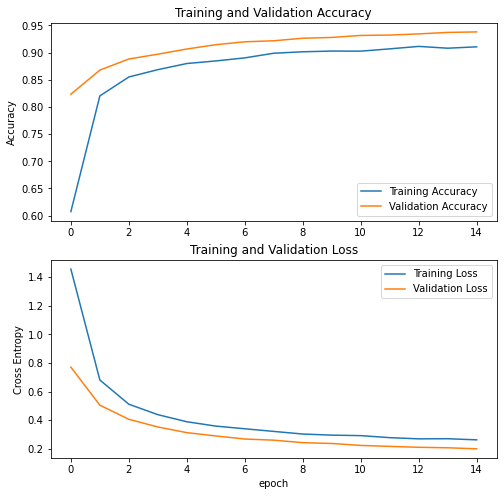

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    initial_epoch=0,
    epochs=FREEZE_EPOCHS,
    validation_data=val_ds,
    # callbacks=[model_checkpoint_callback],
)
historyViewer.update(history)
historyViewer.show()

In [9]:
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
model.summary()

Model: "efficientnetv2-b1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 3, 3, 1280)       6931124   
 al)                                                             
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 6,950,339
Trainable params: 6,808,1

Epoch 16/30
1184/1184 [==============================] - 166s 121ms/step - loss: 0.1873 - accuracy: 0.9353 - val_loss: 0.1055 - val_accuracy: 0.9645
Epoch 17/30
1184/1184 [==============================] - 155s 126ms/step - loss: 0.1340 - accuracy: 0.9531 - val_loss: 0.0687 - val_accuracy: 0.9767
Epoch 18/30
1184/1184 [==============================] - 157s 128ms/step - loss: 0.1007 - accuracy: 0.9635 - val_loss: 0.0521 - val_accuracy: 0.9833
Epoch 19/30
1184/1184 [==============================] - 159s 129ms/step - loss: 0.0796 - accuracy: 0.9717 - val_loss: 0.0412 - val_accuracy: 0.9860
Epoch 20/30
1184/1184 [==============================] - 161s 130ms/step - loss: 0.0643 - accuracy: 0.9766 - val_loss: 0.0291 - val_accuracy: 0.9916
Epoch 21/30
1184/1184 [==============================] - 162s 131ms/step - loss: 0.0532 - accuracy: 0.9803 - val_loss: 0.0234 - val_accuracy: 0.9922
Epoch 22/30
1184/1184 [==============================] - 161s 130ms/step - loss: 0.0438 - accuracy: 0.9844

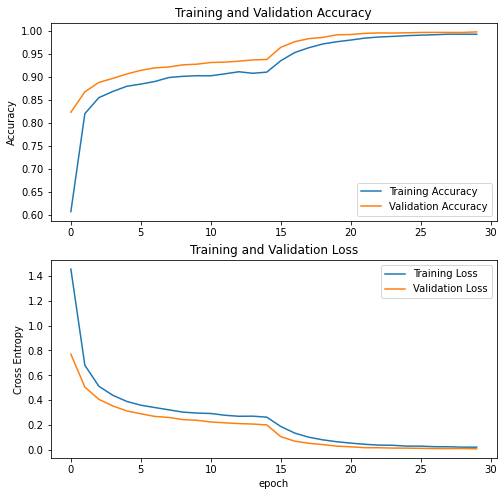

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=UNFREEZE_LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    initial_epoch=FREEZE_EPOCHS,
    epochs=FREEZE_EPOCHS+UNFREEZE_EPOCHS,
    validation_data=val_ds,
    # callbacks=[model_checkpoint_callback],
)
historyViewer.update(history)
historyViewer.show()

In [11]:
model.save(export_path)

INFO:tensorflow:Assets written to: D:/SmartCar/TFLite_Smartcar/saved_models/1659514821\assets


INFO:tensorflow:Assets written to: D:/SmartCar/TFLite_Smartcar/saved_models/1659514821\assets
